# Interferometric oblate star model:

In this notebook, I will demonstrate how to go from the ELR model, which takes only two parameters, a rotation rate $\omega$ and the polar angle on the star $\theta$ to a 3d model of a star, then how to project that model into 2D and extract interferometric observables from the model. All this must be done in jax to maintain differentiability!

In [51]:
import sys
sys.path.append("..")

#import the jaxified ELR model
from core import ELR

import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt

#packages to plot the star using realistic blackbody colors
from colorsys import rgb_to_hls, hls_to_rgb, rgb_to_hsv, hsv_to_rgb
from colorpy import colormodels
from colorpy import blackbody

#Flatiron institute nonuniform fast fourier transform
#will be used to FT the data for interferometric observables
#from jax_finufft import nufft1

## 3d model of the star:

We start by evaluating the radius, temperature and flux at various polar angles on the star as we did in the previous notebook (jax_elr_model_oblate_star.ipynb). Then, I rotate the model about the y (vertical) axis to obtain a 3d representation of the star.

In [31]:
omega = 0.9
latent = jnp.linspace(-1,1,200)
thetas = jnp.linspace(0,jnp.pi,200) #jnp.arccos(latent)
phi = jnp.linspace(0.01, 2*jnp.pi,200)
rtws, Ts, Fs = ELR.solve_ELR_vec(omega, thetas)

<IPython.core.display.Javascript object>


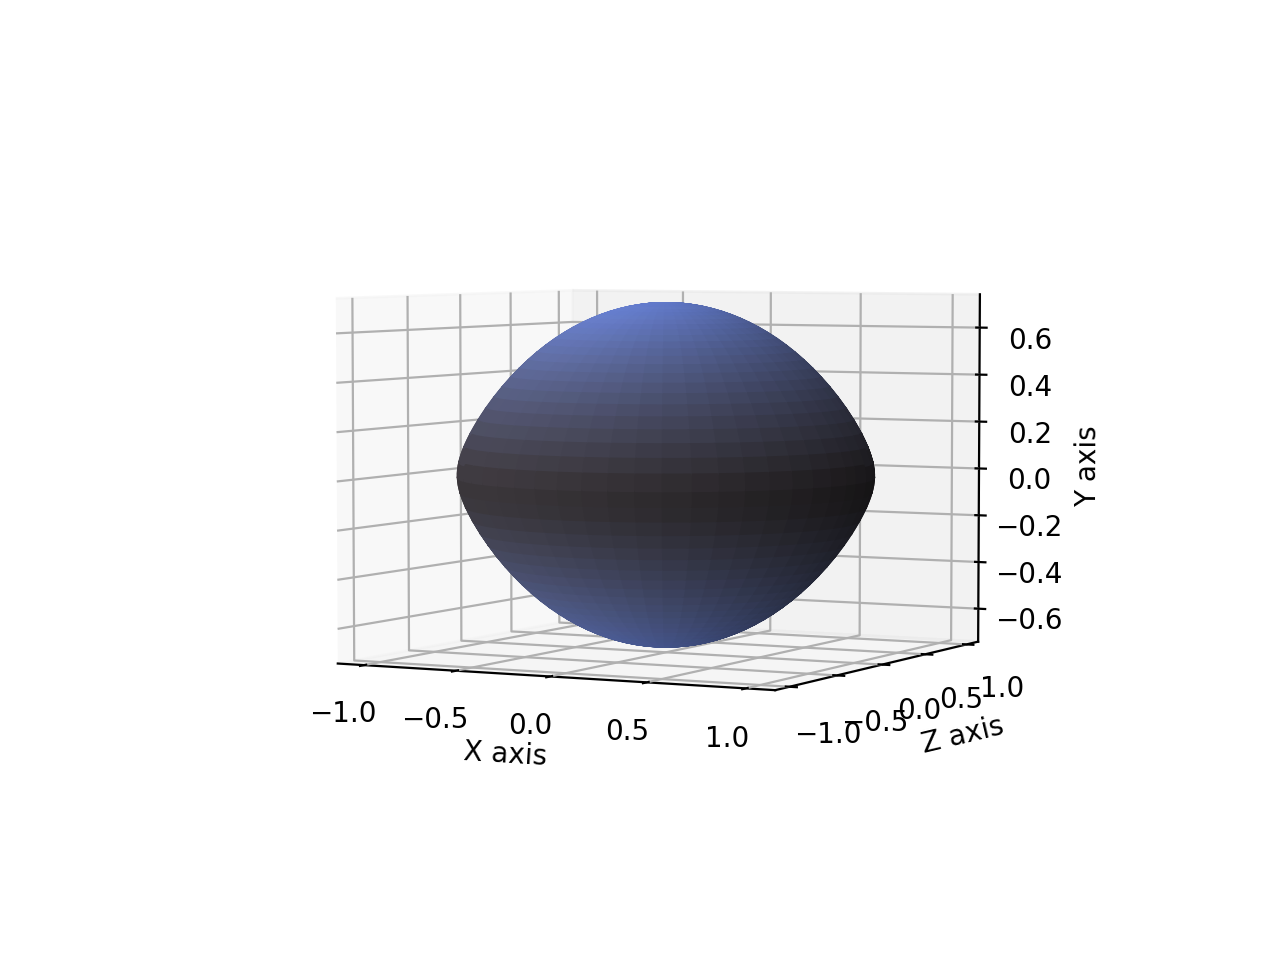

In [42]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('Y axis')

#meshgrid for the surface plot, will have to ravel later into a 1d array
U, V = np.meshgrid(thetas, phi)
Fs = (Fs/jnp.max(Fs))

#blackbody colors for the plot, assuming an average temperature of 7500K
rs, gs, bs = [], [], []
for T, F in zip(Ts, Fs):
    xyz = blackbody.blackbody_color(np.rint(T*7500))
    r,g,b = colormodels.irgb_from_xyz(xyz)
    h,s,v  = rgb_to_hsv(r/ 255.0, g / 255.0, b / 255.0)
    #print(h,s,v)
    v = max(min(v * F, 1.0), 0.0)
    #I apply an arbitrary saturation to make the colors more apparent
    s = max(min(s * 3.0, 1.0), 0.0)
    r, g, b = hsv_to_rgb(h,s,v)
    rs.append(r)
    gs.append(g)
    bs.append(b)

#make the colors the same shape as the surface
rs = np.array(rs)*np.ones_like(V)
gs = np.array(gs)*np.ones_like(V)
bs = np.array(bs)*np.ones_like(V)

#I haven't found a better way to do this;
#Given r, g and b with shape same as X, Y, Z, make into an array of shape (x, 3)
colors = np.einsum('ijk->jki',[rs, gs, bs])

#now perform the rotation--should be same as conversion from cartesian to spherical coords
X = rtws*jnp.sin(U)*jnp.cos(V)
Y = rtws*jnp.cos(U)
Z = rtws*jnp.sin(U)*jnp.sin(V)

#plot the surface along with the colors
ax.plot_surface(X, Z, Y, facecolors=colors)

plt.show()

## Projection into 2D:

Now we project the 3d surface into 2d along the line of sight

In [46]:
#ravel X, Y, Z and R, G, B so we are dealing with point clouds instead of a meshgrid
points = jnp.einsum('ij->ji',[X.ravel(),Y.ravel(),Z.ravel()])
colors = jnp.einsum('ij->ji',[rs.ravel(), gs.ravel(), bs.ravel()])

def incline(i, points):
    rot_mat = jnp.array([[1,0,0],[0,jnp.cos(i),jnp.sin(i)],[0,-jnp.sin(i),jnp.cos(i)]])
    
    return points@rot_mat

#give the star an inclination of 45 degrees
points_rot = incline(jnp.pi/4, points)

<IPython.core.display.Javascript object>


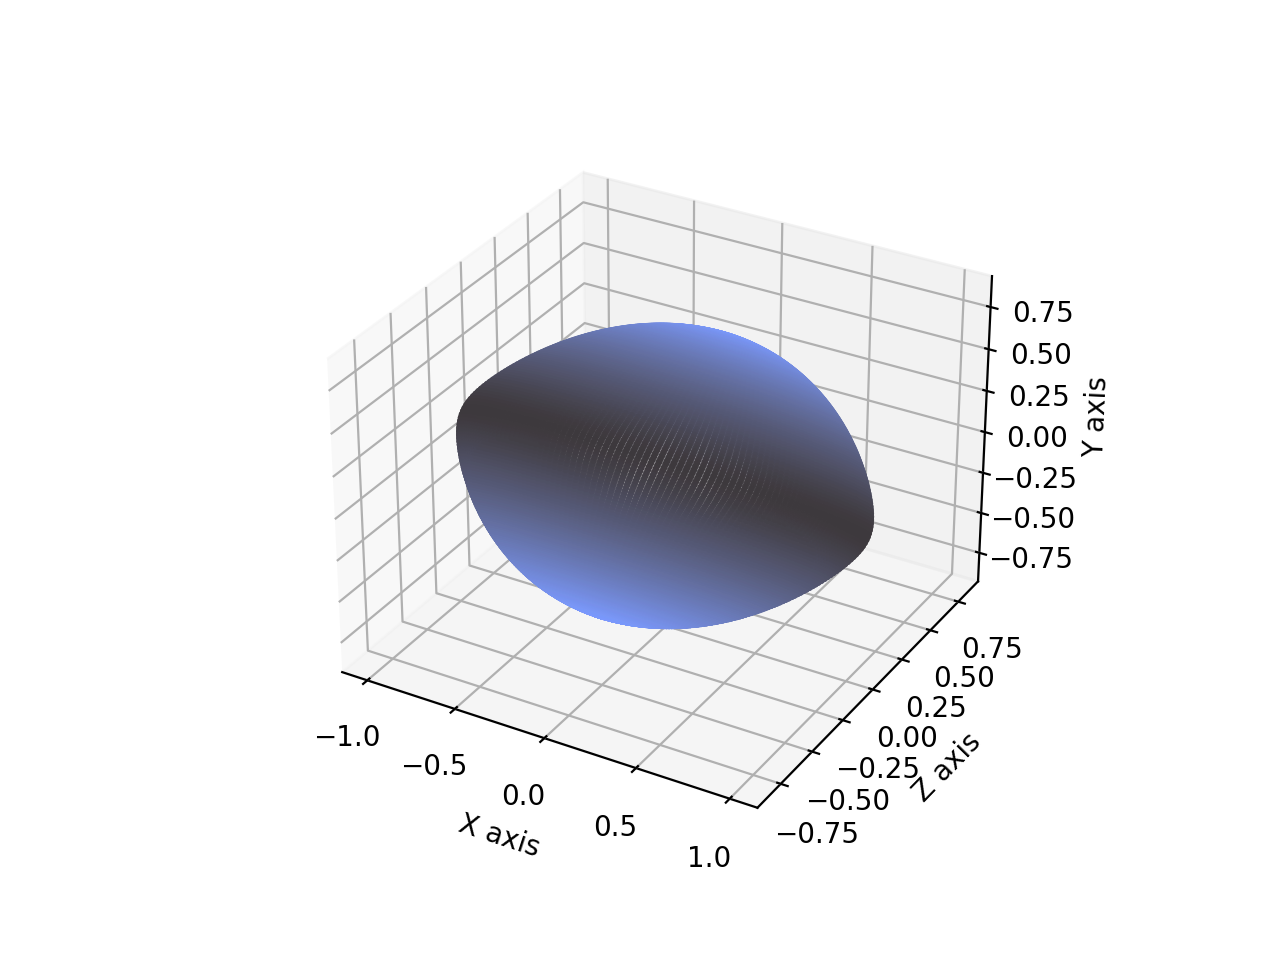

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X axis')
ax.set_ylabel('Z axis')
ax.set_zlabel('Y axis')

ax.scatter(points_rot[:,0],points_rot[:,2],points_rot[:,1], s=2, c=colors)

plt.show()

<IPython.core.display.Javascript object>


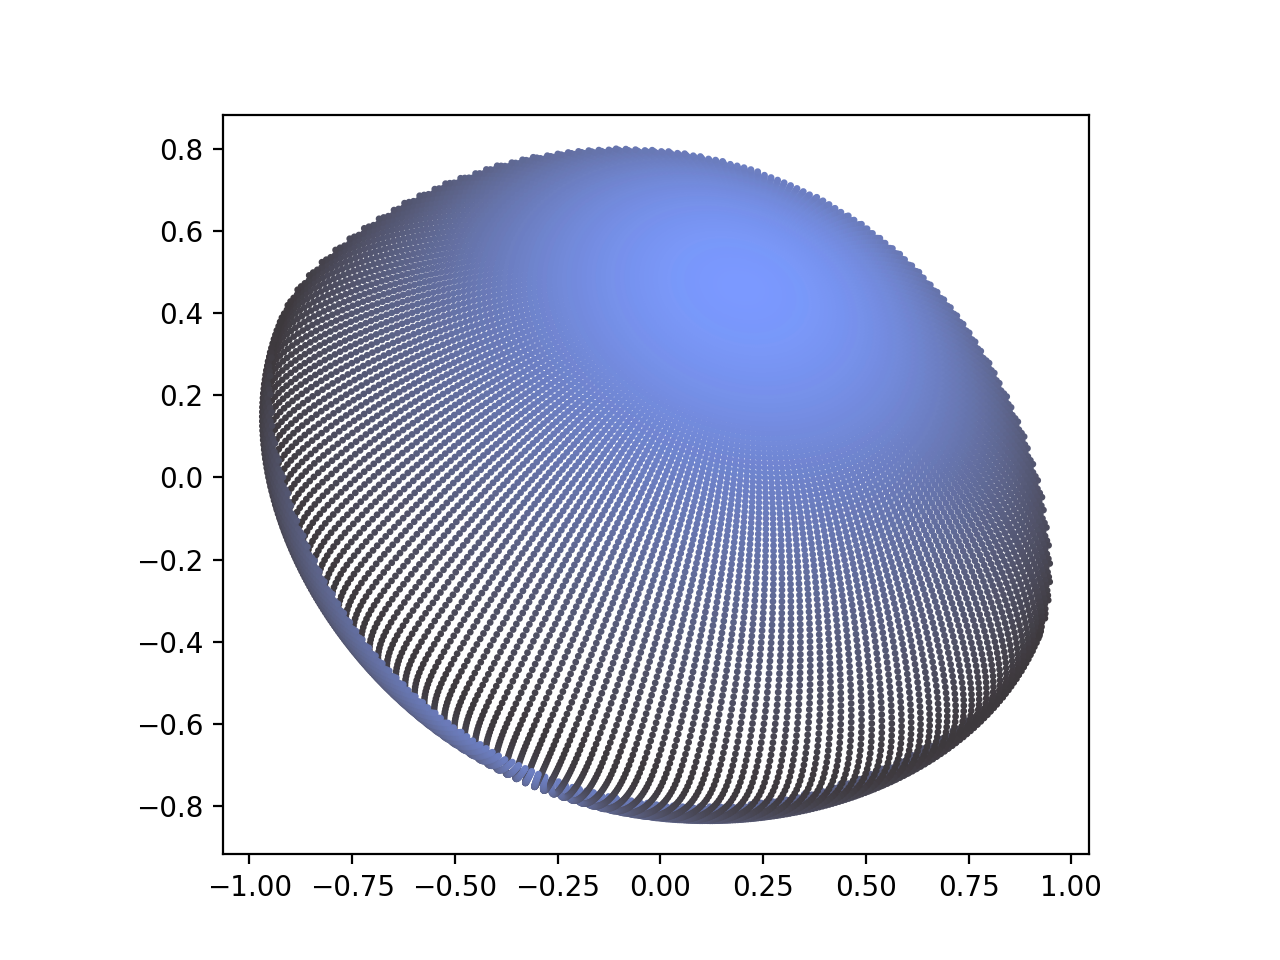

In [49]:
#as a hack, take all the points where z>0 as the front face of the star
#in reality, there are still points where z>0 that are obscured!
#we should ideally ensure the surface normals z_hat > 0
front_ind, = jnp.where(points_rot[:,2]>0)
def rotate(theta, points):
    c, s = jnp.cos(theta), jnp.sin(theta)
    R = jnp.array(((c, -s), (s, c)))
    return points@R

theta = 23
#to project to 2d, simply remove the z axis (inclination already set) 
#and rotate with any arbitrary obliquity
points_rot_2d = rotate(theta*np.pi/180, points_rot[:,0:2])
plt.scatter(points_rot_2d[front_ind,0],points_rot_2d[front_ind,1],c=colors[front_ind],s=2)
plt.gca().set_aspect('equal')

## Fourier transform to extract interferometric observables:

Not yet implemented due to issues with FINUFFT :(